# Classifying Email as Spam or Non-Spam

## Build two models for detecting spam messages:
1. Best model in terms of overall predictive accuracy
2. Best cost-sensitive classification model in terms of average misclassification cost

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
url = "https://archive.ics.uci.edu/static/public/94/data.csv"
spam_df = pd.read_csv(url)
spam_df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Data Processing

In [4]:
# select input and output variables
X = spam_df.drop('Class', axis=1, inplace=False)
y = spam_df['Class']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# normalization
X_train_norm = StandardScaler().fit(X_train).transform(X_train)
X_test_norm = StandardScaler().fit(X_test).transform(X_test)

## 1. Model Selection: Accuracy

- Decision Tree
- KNN
- Logistic Regression
- SVM
- Random Forest
- Gradient Boosting

In [5]:
# Nested Cross-Validation
cv_inner = KFold(n_splits=3, shuffle=True, random_state=42)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=42)

### Decision Tree

In [6]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

param_grid = {
    'max_depth': list(range(1, 21)),
    'criterion': ['gini','entropy']
}

search = GridSearchCV(dt, param_grid, scoring='accuracy', cv=cv_inner, refit=True)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train, y_train, scoring='accuracy', cv=cv_outer)
print('Accuracy: {0:.5f}\nbest parameter: {1}'.format(np.mean(scores), res.best_params_))

Accuracy: 0.90882
best parameter: {'criterion': 'entropy', 'max_depth': 19}


### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': list(range(1,21))}

search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=cv_inner, refit=True)
res = search.fit(X_train_norm, y_train)
scores = cross_val_score(search, X_train_norm, y_train, scoring='accuracy', cv=cv_outer)
print('Accuracy: {0:.5f}\nbest parameter: {1}'.format(np.mean(scores), res.best_params_))

Accuracy: 0.89779
best parameter: {'n_neighbors': 3}


### Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=cv_inner, refit=True)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train, y_train, scoring='accuracy', cv=cv_outer)
print('Accuracy: {0:.5f}\nbest parameter: {1}'.format(np.mean(scores), res.best_params_))

Accuracy: 0.92538
best parameter: {'C': 100}


### SVM

In [23]:
from sklearn.svm import SVC

clf = SVC()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1]
}

search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=cv_inner, refit=True)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train_norm, y_train, scoring='accuracy', cv=cv_outer)
print('Accuracy: {0:.5f}\nbest parameter: {1}'.format(np.mean(scores), res.best_params_))

Accuracy: 0.93122
best parameter: {'C': 10, 'gamma': 0.001}


### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd = RandomForestClassifier()

param_grid = {
    'max_depth': [80, 90, 100],
    'n_estimators': [100, 150, 200, 300],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}

search = RandomizedSearchCV(rnd, param_grid, scoring='accuracy', cv=cv_inner, n_iter=30)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train, y_train, scoring='accuracy', cv=cv_outer)
print('Accuracy: {0:.5f}\nbest parameter: {1}'.format(np.mean(scores), res.best_params_))

Accuracy: 0.94225
best parameter: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 100}


### Gradient Boosting

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

param_grid = {
    'learning_rate': [0.01,0.1,0.2],
    'n_estimators': [100, 150, 200, 250],
    'min_samples_split': [2, 5, 10, 15],
    'max_depth': [3,4,5,6,7,8]
}

search = RandomizedSearchCV(gb, param_grid, scoring='accuracy', cv=cv_inner, n_iter=30)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train, y_train, scoring='accuracy', cv=cv_outer)
print('Accuracy: {0:.5f}\nbest parameter: {1}'.format(np.mean(scores), res.best_params_))

Accuracy: 0.94516
best parameter: {'n_estimators': 200, 'min_samples_split': 15, 'max_depth': 7, 'learning_rate': 0.2}


In [15]:
df_accuracy = pd.DataFrame({
    'Model': ['Decision Tree','KNN','Logistic Regression','SVM','Random Forest','Gradient Boosting'],
    'Accuracy': [0.90882, 0.89779, 0.92538, 0.93122, 0.94225, 0.94516]
})
df_accuracy.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
5,Gradient Boosting,0.94516
4,Random Forest,0.94225
3,SVM,0.93122
2,Logistic Regression,0.92538
0,Decision Tree,0.90882
1,KNN,0.89779


## Performance Evaluation

In [51]:
# Build and fit the model using the best model - Gradient Boosting
gb_best = GradientBoostingClassifier(n_estimators=200, min_samples_split=15, max_depth=7, learning_rate=0.2)
gb_best.fit(X_train, y_train)
y_pred = gb_best.predict(X_test)
y_score = gb_best.predict_proba(X_test)

In [52]:
print("accuracy: " + str(round(metrics.accuracy_score(y_test, y_pred),5)))

accuracy: 0.96182


In [53]:
# Evaluate model performance
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       897
           1       0.96      0.95      0.95       622

    accuracy                           0.96      1519
   macro avg       0.96      0.96      0.96      1519
weighted avg       0.96      0.96      0.96      1519



In [54]:
metrics.confusion_matrix(y_test, y_pred)

array([[873,  24],
       [ 34, 588]])

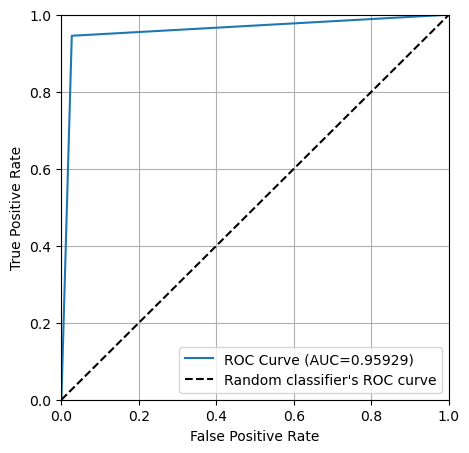

In [55]:
# Plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 5)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label="ROC Curve (AUC=" + str(auc) + ")")
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC curve")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.axis([0, 1, 0, 1])
plt.show()

<Figure size 800x600 with 0 Axes>

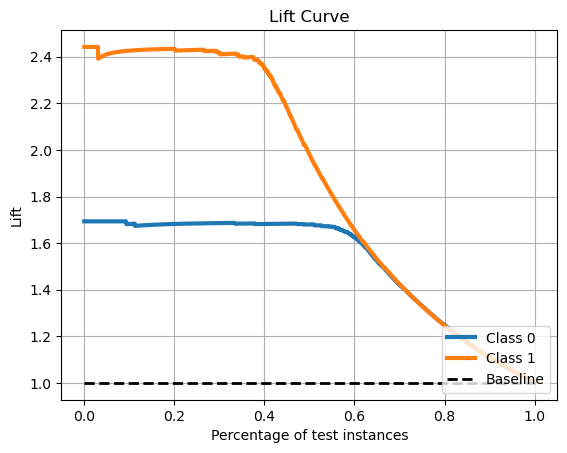

In [56]:
# Plot lift curve
import scikitplot as skplt
plt.figure(figsize=(8, 6))
skplt.metrics.plot_lift_curve(y_test, y_score)
plt.title('Lift Curve')
plt.xlabel("Percentage of test instances")
plt.ylabel("Lift")
plt.show()

## 2. Model Selection: Average Missclassification Cost
- Decision Tree
- KNN
- Logistic Regression
- SVM
- Random Forest
- Gradient Boosting

In [ ]:
from sklearn.metrics import confusion_matrix, make_scorer

# Define cost matrix
cost_matrix = np.array([[0, 1], [10, 0]])

# Define a function to calculate misclassification cost
def missclassification_cost(y_true, y_pred):
    return np.sum(cost_matrix * confusion_matrix(y_true, y_pred)) / len(y_true)

# Create a scorer using the defined misclassification cost function
cost = make_scorer(missclassification_cost, greater_is_better=False)

In [22]:
# Nested Cross-Validation
cv_inner = KFold(n_splits=3, shuffle=True, random_state=42)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=42)

### Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

param_grid = {
    'max_depth': list(range(1, 21)),
    'criterion': ['gini','entropy']
}

search = GridSearchCV(dt, param_grid, scoring=cost, cv=cv_inner)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train, y_train, scoring=cost, cv=cv_outer)
print('average misclassification cost: {0:.5f}'.format(np.mean(scores)))
print(res.best_params_)

average misclassification cost: -0.51261
{'criterion': 'entropy', 'max_depth': 16}


### KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': list(range(1,21))}

search = GridSearchCV(knn, param_grid, scoring=cost, cv=cv_inner)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train_norm, y_train, scoring=cost, cv=cv_outer)
print('average misclassification cost: {0:.5f}'.format(np.mean(scores)))
print(res.best_params_)

average misclassification cost: -0.51617
{'n_neighbors': 1}


### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

search = GridSearchCV(lr, param_grid, scoring=cost, cv=cv_inner)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train, y_train, scoring=cost, cv=cv_outer)
print('average misclassification cost: {0:.5f}'.format(np.mean(scores)))
print(res.best_params_)

average misclassification cost: -0.49414
{'C': 1}


### SVM

In [37]:
from sklearn.svm import SVC

clf = SVC()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1]
}

search = GridSearchCV(clf, param_grid, scoring=cost, cv=cv_inner)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train_norm, y_train, scoring=cost, cv=cv_outer)
print('average misclassification cost: {0:.5f}'.format(np.mean(scores)))
print(res.best_params_)

average misclassification cost: -0.45587
{'C': 10, 'gamma': 0.01}


### Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

rnd = RandomForestClassifier()

# define hyparameter to search
param_grid = {
    'max_depth': [80, 90, 100],
    'n_estimators': [100, 150, 200, 250, 300],
    'min_samples_split':[2,5,8,10],
    'min_samples_leaf': [3, 4, 5]
}

search = GridSearchCV(rnd, param_grid, scoring=cost, cv=cv_inner)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train, y_train, scoring=cost, cv=cv_outer)
print('average misclassification cost: {0:.5f}'.format(np.mean(scores)))
print(res.best_params_)

average misclassification cost: -0.52751
{'max_depth': 7, 'min_samples_split': 7, 'n_estimators': 200}


### Gradient Boosting

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

param_grid = {
    'learning_rate': [0.01,0.1,0.2],
    'n_estimators': [100, 150, 200, 250],
    'min_samples_split': [2, 5, 10, 15],
    'max_depth': [3,4,5]
}

search = RandomizedSearchCV(gb, param_grid, scoring=cost, cv=cv_inner, n_iter=30)
res = search.fit(X_train, y_train)
scores = cross_val_score(search, X_train, y_train, scoring=cost, cv=cv_outer)
print('average misclassification cost: {0:.5f}'.format(np.mean(scores)))
print(res.best_params_)

average misclassification cost: -0.30600
{'n_estimators': 250, 'min_samples_split': 10, 'max_depth': 4, 'learning_rate': 0.2}


In [17]:
df_cost = pd.DataFrame({
    'Model': ['Decision Tree','KNN','Logistic Regression','SVM','Random Forest','Gradient Boosting'],
    'Misclassification Cost': [-0.51261, -0.51617, -0.49414, -0.45587, -0.52751, -0.30600]
})
df_cost.sort_values(by='Misclassification Cost', ascending=False)

,Model,Misclassification Cost
5,Gradient Boosting,-0.30600
3,SVM,-0.45587
2,Logistic Regression,-0.49414
0,Decision Tree,-0.51261
1,KNN,-0.51617
4,Random Forest,-0.52751


## Performance Evaluation

In [42]:
# Build and fit the model using the best model - Gradient Boosting
gb_best = GradientBoostingClassifier(learning_rate=0.2, n_estimators=250, max_depth=4, min_samples_split=10)
gb_best.fit(X_train, y_train)
y_pred = gb_best.predict(X_test)
y_score = gb_best.predict_proba(X_test)

In [43]:
print("accuracy: " + str(round(metrics.accuracy_score(y_test, y_pred),5)))

accuracy: 0.96116


In [44]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       897
           1       0.96      0.95      0.95       622

    accuracy                           0.96      1519
   macro avg       0.96      0.96      0.96      1519
weighted avg       0.96      0.96      0.96      1519



In [45]:
confusion_matrix(y_test, y_pred)

array([[872,  25],
       [ 34, 588]])

In [46]:
missclassification_cost(y_test, y_pred)

0.24028966425279788

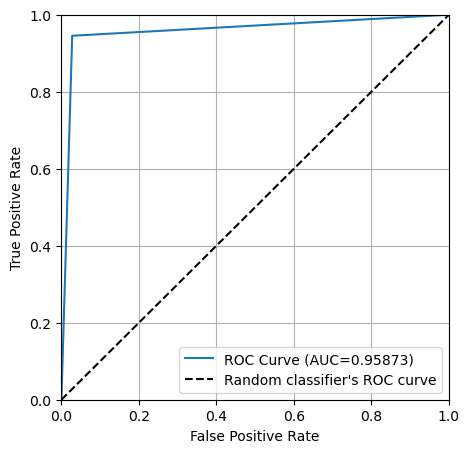

In [47]:
# Plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 5)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label="ROC Curve (AUC=" + str(auc) + ")")
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC curve")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.axis([0, 1, 0, 1])
plt.show()

<Figure size 800x600 with 0 Axes>

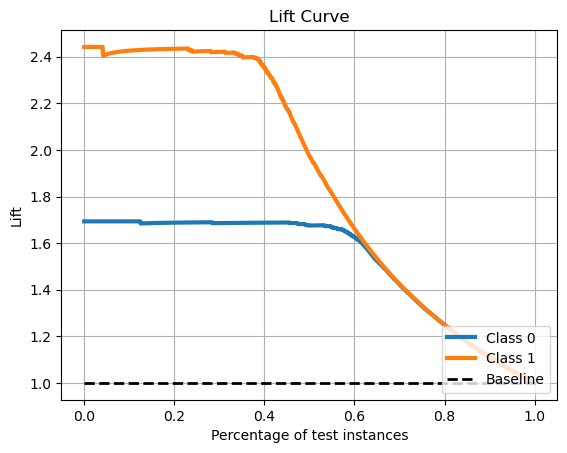

In [48]:
# Plot lift curve
import scikitplot as skplt
plt.figure(figsize=(8, 6))
skplt.metrics.plot_lift_curve(y_test, y_score)
plt.title('Lift Curve')
plt.xlabel("Percentage of test instances")
plt.ylabel("Lift")
plt.show()